In [1]:
import torch, torchvision
from torchvision.io import read_image
from torchvision import transforms

In [3]:
torch.cuda.is_available()

True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
!wget https://www.cosy.sbg.ac.at/~pmeerw/Watermarking/lena_gray.gif

In [2]:
from PIL import Image

In [ ]:
im = Image.open('lena_gray.gif') #.convert('L')
#im = Image.open('five.png').convert('L')

In [ ]:
#gray_image = torchvision.transforms.Grayscale()(im)

In [ ]:
#im.mode

In [3]:
import numpy as np

In [ ]:
im = np.array(im)

In [4]:
import matplotlib.pyplot as plt

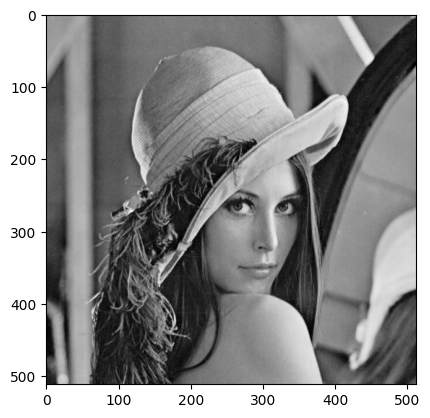

In [ ]:
plt.imshow(im, cmap='gray')

In [ ]:
np.array(im).shape

(512, 512)

In [ ]:
kernel = torch.tensor([[1,0,-1],[1,0,-1],[1,0,-1]]).to(torch.float)
#kernel = 0.2*torch.ones(3,3)

In [ ]:
kernel

tensor([[0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000]])

In [7]:
import torch.nn as nn

In [8]:
from torch.nn.functional import conv2d

In [ ]:
conv = conv2d(torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0))

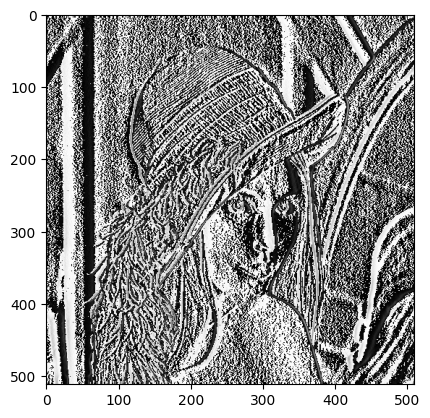

In [ ]:
plt.imshow(im[:,:-2]-im[:,2:], cmap='gray',vmin=0, vmax=255)

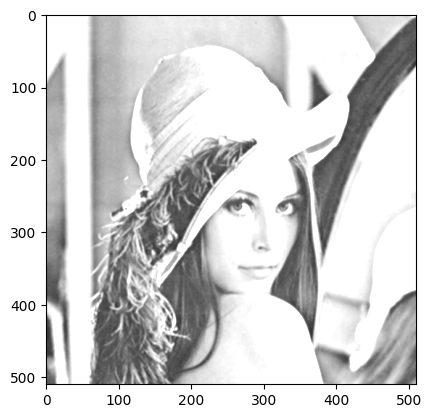

In [ ]:
plt.imshow(conv.abs().squeeze(0).permute(1,2,0), cmap='gray', vmin=0, vmax=255)

In [43]:
!wget https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2023/seminars/03.%20Image%20Classification/filter_viz.py

In [ ]:
from filter_viz import plot_filters

In [16]:
import torchvision.transforms.v2 as T

In [10]:
transform = T.Compose(
    [
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=transform
)

100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s]


In [42]:
#cifar_train[70][0]

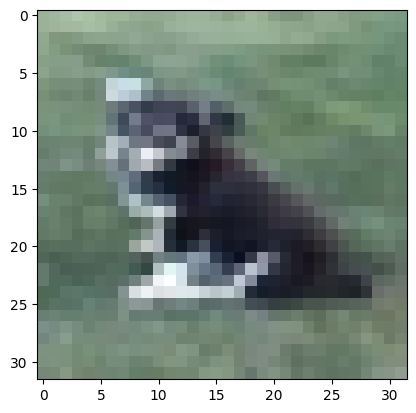

In [16]:
plt.imshow(cifar_train[70][0].permute(1,2,0)*torch.tensor([0.247, 0.243, 0.261])+torch.tensor([0.4914, 0.4822, 0.4465]))

In [ ]:
cifar_train[70][1]

5

In [12]:
train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True, num_workers=2
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False, num_workers=2
)

In [13]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img * torch.tensor([0.247, 0.243, 0.261])+torch.tensor([0.4914, 0.4822, 0.4465]) # / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0))*np.array([0.247, 0.243, 0.261])+np.array([0.4914, 0.4822, 0.4465]))


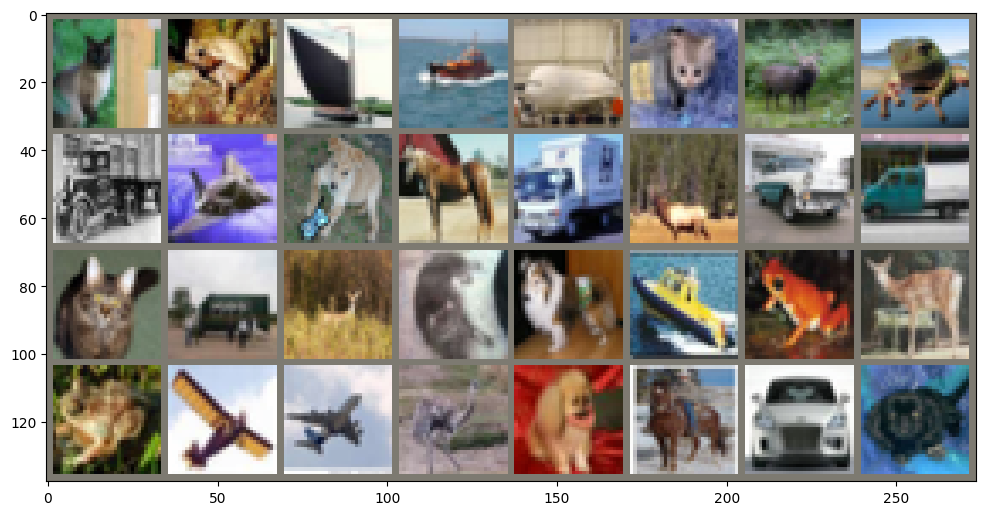

In [ ]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [14]:
import torch.nn.functional as F

In [15]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.VGG = nn.Sequential(nn.Conv2d(3,16,3, padding=1), nn.ReLU(), nn.Conv2d(16,16,5, padding=2), nn.ReLU(), nn.MaxPool2d(2,2))
    self.fc1 = nn.Linear(16**3, 128)
    self.fc2 = nn.Linear(128,10)
    self.flat = nn.Flatten()

  def forward(self, x):
    x = self.VGG(x)
    x = self.flat(x)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x



In [16]:
model = MyModel()

In [41]:
model.to(device)

In [19]:
model.forward(torch.zeros(2, 3, 32, 32).to(device))

tensor([[ 0.0510,  0.0438,  0.0236, -0.0668, -0.0661, -0.0091,  0.0149, -0.0505,
         -0.0920,  0.0364],
        [ 0.0510,  0.0438,  0.0236, -0.0668, -0.0661, -0.0091,  0.0149, -0.0505,
         -0.0920,  0.0364]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
from torch.optim import Adam

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [22]:
from tqdm import tqdm

In [6]:
for epoch in range(10):
  model.train()
  for x, y in tqdm(train_dataloader):
    y_pred = model.forward(x.to(device))
    loss = criterion(y_pred, y.to(device))
    loss.backward()
    loss = loss.detach()
    optimizer.step()
    optimizer.zero_grad()
  with torch.no_grad():
    model.eval()
    acc = []
    for x,y in val_dataloader:
      y_pred = model.forward(x.to(device)).argmax(-1)
      acc.append((y_pred.cpu() == y).sum()/len(y))
  print(loss.item(), np.mean(acc))

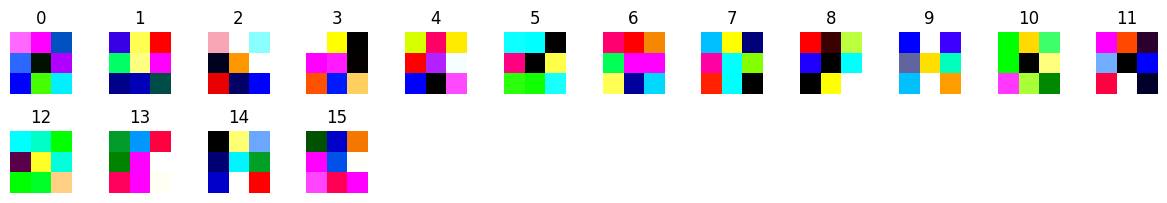

In [ ]:
plot_filters(model.VGG[0], single_channel=False)

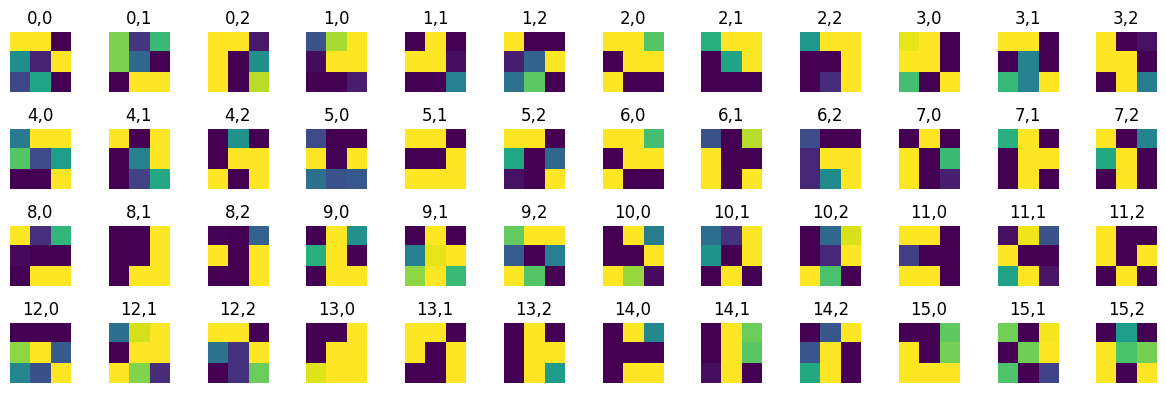

In [ ]:
plot_filters(model.VGG[0], single_channel=True)

In [8]:
import albumentations as A

In [8]:
!wget https://www.cs.rit.edu/~ams/Pine.png

--2025-04-18 22:18:03--  https://www.cs.rit.edu/~ams/Pine.png
Resolving www.cs.rit.edu (www.cs.rit.edu)... 129.21.34.17
Connecting to www.cs.rit.edu (www.cs.rit.edu)|129.21.34.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1599631 (1.5M) [image/png]
Saving to: ‘Pine.png’

Pine.png            100%[===================>]   1.53M  3.28MB/s    in 0.5s    

2025-04-18 22:18:04 (3.28 MB/s) - ‘Pine.png’ saved [1599631/1599631]



In [5]:
im = Image.open('Pine.png').convert('RGB')

In [16]:
im = T.ToDtype(dtype=torch.float32, scale=True)(T.ToImage()(im))
im.shape

torch.Size([3, 1024, 768])

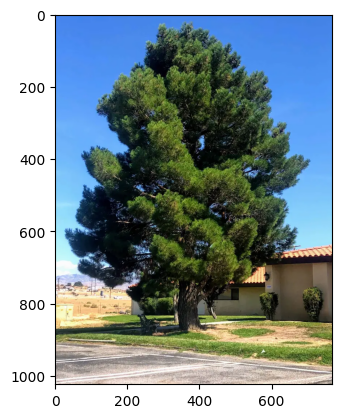

In [17]:
plt.imshow(im.permute(1,2,0))

In [6]:
from albumentations.pytorch import ToTensorV2

In [13]:
MyTransform = A.Compose([
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
        ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


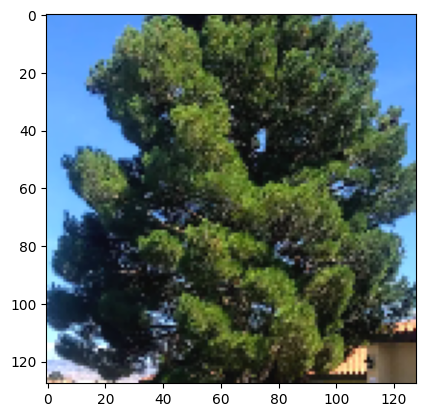

In [14]:
im1 = MyTransform(image=np.array(im))['image']
plt.imshow(im1.permute(1,2,0)*torch.tensor([0.247, 0.243, 0.261])+torch.tensor([0.4914, 0.4822, 0.4465]))